In [24]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from sklearn import metrics, utils
from joblib import Parallel, delayed
from tqdm import tqdm#_notebook as tqdm
import scipy
import scipy.special
import itertools
import yaml

with open('config.yaml') as f:
    config = yaml.load(f)
    data_path = config['data_path']

# Ashutosh suppress warnings :
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
# Ashutosh extra imports : 
from sklearn.metrics import classification_report,confusion_matrix


In [25]:
# Ashutosh updating the font needed : 
matplotlib.rcParams['font.size'] = 16.0

matplotlib.rcParams['font.family'] = 'sans-serif'
"""
matplotlib.rcParams['font.sans-serif'] = [
    'Roboto',
    'DejaVu Sans',
    'sans-serif'
]
"""
matplotlib.rcParams['font.sans-serif'] = [
   'Tahoma', 
    'DejaVu Sans',
    'Lucida Grande'
]

In [26]:
figure_dim = 4.0

In [27]:
#tasks = ['ARF', 'Shock']
#tasks = ['mortality']
#Ts = [4, 12]

# Commenting for other models  :
models = ['RF', 'CNN_V3', 'RNN_V2', ]
#colors = ['#d62728', '#1f77b4', '#ff7f0e']
colors = ['lime', 'orangered', 'dodgerblue']

### Ashutosh pre-requisites before running below codes :

1. To move the files from the Model path to data-out path first :
2. Create a directory called figures in the current path :

In [28]:
dt = 1.0
output = {}

# Ashutosh commenting as not interested in ARF and Shock outcomes :
"""
for task in tasks:
    output[task] = {}
    for T in Ts:
        output[task][T] = {}
        for model in models:
            f = np.load(open('output/outcome={}.T={}.dt={}/{}.test.npz'.format(task, T, dt, model), 'rb'))
            y_score, y_true = f['y_score'], f['y_true']
            output[task][T][model] = (y_score, y_true)
        
        # Check all test sets are equal
        y_trues = [y_true for _, y_true in output[task][T].values()]
        assert all((e == y_trues[0]).all() for e in y_trues)
"""

task = 'mortality'
output[task] = {}
# Ashutosh updated 48 to 48.0 below :
T = 48.0
output[task][T] = {}
for model in models:
    # Ashutosh updated the corrected path :
    #f = np.load(open('output/outcome={}.T={}.dt={}/{}.test.npz'.format(task, T, dt, model), 'rb'))
    f = np.load(open(data_path + 'output/outcome={}.T={}.dt={}/{}.test.npz'.format(task, T, dt, model), 'rb'))
    y_score, y_true = f['y_score'], f['y_true']
    output[task][T][model] = (y_score, y_true)

# Check all test sets are equal: 
y_trues = [y_true for _, y_true in output[task][T].values()]
assert all((e == y_trues[0]).all() for e in y_trues)

## ROC curves and Statistical Methods :

In [29]:
list_new = [] 
y_true = []

def plot_roc_curves(task, T):
    
    def bootstrap_func(i, y_true, y_score):
        yte_true_b, yte_pred_b = utils.resample(y_true, y_score, replace=True, random_state=i)
        return metrics.roc_curve(yte_true_b, yte_pred_b), metrics.roc_auc_score(yte_true_b, yte_pred_b)
        
        
    def find_threshold_plot(tpr,fpr):
        # Ashutosh added this for the classification report and confusion matrix : 
        """Function to calculate the best threshold  Youden's J statistic"""
        
        # Calculate the G-mean
        gmean = np.sqrt(tpr * (1 - fpr))
    
        # Calculate the Youden's J statistic
        youdenJ = tpr - fpr

        # Find the optimal threshold
        index = np.argmax(youdenJ)
        thresholdOpt = round(thresholds[index], ndigits = 4)
        youdenJOpt = round(gmean[index], ndigits = 4)
        fprOpt = round(fpr[index], ndigits = 4)
        tprOpt = round(tpr[index], ndigits = 4)
        print('Best Threshold: {} with Youden J statistic: {}'.format(thresholdOpt, youdenJOpt))
        print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))
        return thresholdOpt      
        

    def get_roc_CI(y_true, y_score):
        roc_curves, auc_scores = zip(*Parallel(n_jobs=4)(delayed(bootstrap_func)(i, y_true, y_score) for i in range(1000)))
        print('Test AUC: {:.3f}'.format(metrics.roc_auc_score(y_true, y_score)))
        print('Test AUC: ({:.3f}, {:.3f}) percentile 95% CI'.format(np.percentile(auc_scores, 2.5), np.percentile(auc_scores, 97.5)))
        
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        for fpr, tpr, _ in roc_curves:
            tprs.append(scipy.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            aucs.append(metrics.auc(fpr, tpr))

        mean_tpr = np.mean(tprs, axis=0)
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + 1.96 * std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - 1.96 * std_tpr, 0)

        return roc_curves, auc_scores, mean_fpr, tprs_lower, tprs_upper

    fig, ax = plt.subplots(figsize=(figure_dim, figure_dim))
    true_auc_scores = []
    bootstrap_auc_scores = []
    
    
    global list_new, y_true
    for model, color in zip(models, colors):
        print(model)
        y_score, y_true = output[task][T][model]
        true_auc_scores.append(metrics.roc_auc_score(y_true, y_score))
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
        
        # Ashutosh calculate and print Brier Score
        brier = metrics.brier_score_loss(y_true, y_score)
        print('Brier Score: %.3f' % (brier))
        
        # Ashutosh find the threshold using the Youden's J statistic:
        threshold_out = find_threshold_plot(tpr,fpr)
        plt.plot(fpr, tpr, lw=1.25, label=model, color=color)
        
        roc_curves, auc_scores, mean_fpr, tprs_lower, tprs_upper = get_roc_CI(y_true, y_score)
        
        y_score_new = list(map(lambda x : 1 if x>threshold_out else 0, y_score))
        
        # Ashutosh print classification report :
        print(metrics.classification_report(y_true,y_score_new))
        list_new.append(y_score_new)
        
        bootstrap_auc_scores.append(np.array(auc_scores))
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=.1, color=color)
        
    #return list_new, y_true

    # Statistical tests
    df_pval = pd.DataFrame(index=models, columns=models)
    for (i, model_i), (j, model_j) in itertools.product(enumerate(models), enumerate(models)):
        bootstrap_auc_scores[i], bootstrap_auc_scores[j]
        pvalue = 2 * min(
            (bootstrap_auc_scores[i] < bootstrap_auc_scores[j]).mean(),
            (bootstrap_auc_scores[i] > bootstrap_auc_scores[j]).mean(),
        )
        df_pval.iloc[i,j] = pvalue
    display(df_pval)
    
    # The order must be the same as how the files are loaded in
    # Ashutosh commenting below for everything except RF :
    lg = plt.legend(
        [
          #  '   LR   : {:.3f}'.format(true_auc_scores[0]), 
            '   RF   : {:.3f}'.format(true_auc_scores[0]), 
            ' CNN : {:.3f}'.format(true_auc_scores[1]), 
            'LSTM: {:.3f}'.format(true_auc_scores[2]), 
        ],
        title='AUROC',
        loc='lower right',
        handlelength=1.0,
        fontsize=9,
    )
    lg.get_title().set_fontsize(10)
    plt.plot([0,1], [0,1], 'k:')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim(0,1)
    plt.ylim(0,1)
    
    #plt.title('{}.T={}.dt={}'.format(task, T, dt))
    plt.tight_layout()
    
    plt.figure(figsize = (7,7))
    
    plt.savefig('figures/ROC.{}.T={}.dt={}.svg'.format(task, T, dt))
    plt.show()
    

In [30]:
# Ashutosh added fn for confusion matrix and saving :
def Plot_confusion_matrix(y_test, pred_test, model_name):
    cm = confusion_matrix(y_test, pred_test)
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)
    classNames = ['Survived','Death']
    plt.title(' Confusion Matrix -- Test Data ' + model_name)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    model_list = ['RF','CNN','LSTM']
    
    #plt.figure(figsize = (5,5))
  
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),fontsize=10)
    
    plt.show()

RF
Brier Score: 0.081
Best Threshold: 0.12 with Youden J statistic: 0.7372
FPR: 0.3595, TPR: 0.8485
Test AUC: 0.820
Test AUC: (0.784, 0.853) percentile 95% CI
              precision    recall  f1-score   support

           0       0.97      0.64      0.77      1132
           1       0.22      0.85      0.34       132

    accuracy                           0.66      1264
   macro avg       0.59      0.74      0.56      1264
weighted avg       0.89      0.66      0.73      1264

CNN_V3
Brier Score: 0.066
Best Threshold: 0.09889999777078629 with Youden J statistic: 0.8341
FPR: 0.2014, TPR: 0.8712
Test AUC: 0.891
Test AUC: (0.859, 0.919) percentile 95% CI
              precision    recall  f1-score   support

         0.0       0.98      0.80      0.88      1132
         1.0       0.33      0.86      0.48       132

    accuracy                           0.81      1264
   macro avg       0.66      0.83      0.68      1264
weighted avg       0.91      0.81      0.84      1264

RNN_V2
Br

,RF,CNN_V3,RNN_V2
RF,0.0,0.0,0.0
CNN_V3,0.0,0.0,0.044
RNN_V2,0.0,0.044,0.0


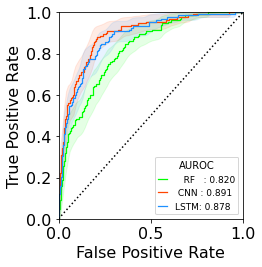

<Figure size 504x504 with 0 Axes>

In [31]:
plot_roc_curves(task = 'mortality', T = 48.0)

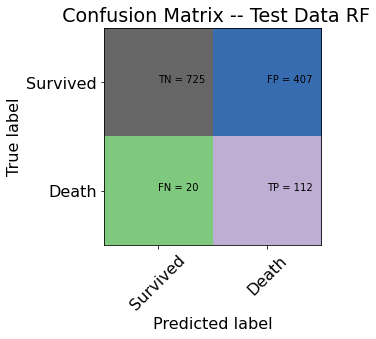

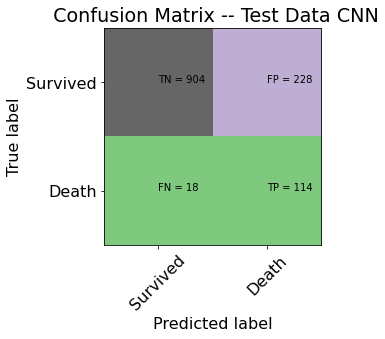

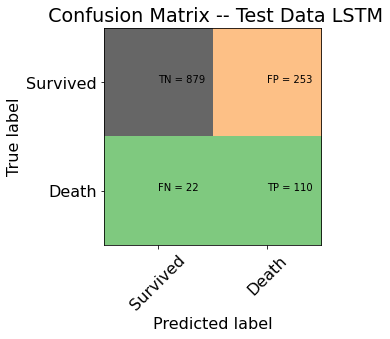

In [32]:
# Ashutosh plot the confusion matrix :

for l in zip(list_new,['RF','CNN','LSTM']):
    Plot_confusion_matrix(y_true,l[0],l[1])

## PR curves

In [33]:
def plot_pr_curves(task, T):
    
    def bootstrap_func(i, y_true, y_score):
        yte_true_b, yte_pred_b = utils.resample(y_true, y_score, replace=True, random_state=i)
        return (
            metrics.precision_recall_curve(yte_true_b, yte_pred_b), 
            metrics.auc(*metrics.precision_recall_curve(yte_true_b, yte_pred_b)[1::-1])
        )

    def get_pr_CI(y_true, y_score):
        curves, scores = zip(*Parallel(n_jobs=4)(delayed(bootstrap_func)(i, y_true, y_score) for i in range(1000)))
        print('Test AUPR: {:.3f}'.format(metrics.auc(*metrics.precision_recall_curve(y_true, y_score)[1::-1])))
        print('Test AUPR: ({:.3f}, {:.3f}) percentile 95% CI'.format(np.percentile(scores, 2.5), np.percentile(scores, 97.5)))
#         print('Test AUPR: {:.3f} ({:.3f}, {:.3f}) percentile'.format(np.median(scores), np.percentile(scores, 2.5), np.percentile(scores, 97.5)))
#         print('Test AUPR: {:.3f} ({:.3f}, {:.3f}) empirical'.format(np.mean(scores), np.mean(scores) - 1.96 * np.std(scores), np.mean(scores) + 1.96 * np.std(scores)))
#         print('Test AUPR: {:.3f} ± {:.3f} SE'.format(np.mean(scores), np.std(scores)))
        
        precs = []
        mean_rec = np.linspace(0, 1, 101)
        for prec, rec, _ in curves:
            rec_sorted, prec_sorted = rec[np.argsort(rec)], prec[np.argsort(rec)]
            precs.append(np.interp(mean_rec, rec_sorted, prec_sorted))
        
        mean_prec = np.mean(precs, axis=0)
        std_prec = np.std(precs, axis=0)
        prec_upper = np.minimum(mean_prec + 1.96 * std_prec, 1)
        prec_lower = np.maximum(mean_prec - 1.96 * std_prec, 0)
        return curves, scores, mean_rec, prec_lower, prec_upper

    fig = plt.figure(figsize=(figure_dim, figure_dim))
    aupr_scores = []
    bootstrap_aupr_scores = []
    for model, color in zip(models, colors):
        print(model)
        y_score, y_true = output[task][T][model]
        precision, recall, thresholds_ = metrics.precision_recall_curve(y_true, y_score)
        plt.plot(recall, precision, lw=1.25, label=model, color=color)
        aupr_scores.append(metrics.auc(recall, precision))
        curves, scores, mean_rec, prec_lower, prec_upper = get_pr_CI(y_true, y_score)
        bootstrap_aupr_scores.append(np.array(scores))
        plt.fill_between(mean_rec, prec_lower, prec_upper, alpha=.05, color=color)
    
    # Statistical tests
    df_pval = pd.DataFrame(index=models, columns=models)
    for (i, model_i), (j, model_j) in itertools.product(enumerate(models), enumerate(models)):
        bootstrap_aupr_scores[i], bootstrap_aupr_scores[j]
        pvalue = 2 * min(
            (bootstrap_aupr_scores[i] < bootstrap_aupr_scores[j]).mean(),
            (bootstrap_aupr_scores[i] > bootstrap_aupr_scores[j]).mean(),
        )
        df_pval.iloc[i,j] = pvalue
    display(df_pval)
    
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    lg = plt.legend(
        [
           # '   LR   : {:.3f}'.format(aupr_scores[0]), 
            '   RF   : {:.3f}'.format(aupr_scores[0]), 
            ' CNN : {:.3f}'.format(aupr_scores[1]), 
            'LSTM: {:.3f}'.format(aupr_scores[2]), 
        ], 
        title='AUPR',
        loc='best',
#         loc='lower left',
        handlelength=1.0,
        fontsize=9,
    )
    lg.get_title().set_fontsize(10)
#     plt.title('{}.T={}.dt={}'.format(task, T, dt))
    plt.tight_layout()
    plt.savefig('figures/PR.{}.T={}.dt={}.svg'.format(task, T, dt))
    plt.show()

RF
Test AUPR: 0.368
Test AUPR: (0.287, 0.461) percentile 95% CI
CNN_V3
Test AUPR: 0.524
Test AUPR: (0.427, 0.624) percentile 95% CI
RNN_V2
Test AUPR: 0.502
Test AUPR: (0.407, 0.593) percentile 95% CI


,RF,CNN_V3,RNN_V2
RF,0.0,0.0,0.0
CNN_V3,0.0,0.0,0.418
RNN_V2,0.0,0.418,0.0


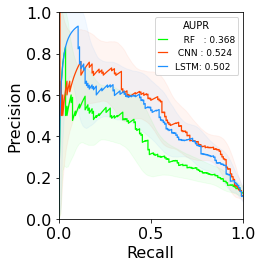

In [34]:
plot_pr_curves('mortality', 48)

## Calibration

In [35]:
def get_calibration_plot(y_true, y_prob, q):
    try:
        out, bins = pd.qcut(y_prob.ravel(), q=q, labels=False, retbins=True)
#         bins = np.percentile(y_prob.ravel(), [0, 20, 40, 60, 80, 100])
        P_true, P_pred = [], []
        for bin_idx in range(q):
            m = (out == bin_idx)
            P_true.append(np.mean(y_true[m]))
            P_pred.append(np.mean(y_prob[m]))
    except:
        print(q)
        print(out)
        raise
    return P_true, P_pred

In [36]:
def plot_calibration_curves(task, T):
    
    def bootstrap_func(i, y_true, y_score, q):
        yte_true_b, yte_pred_b = utils.resample(y_true, y_score, replace=True, random_state=i)
        return get_calibration_plot(yte_true_b, yte_pred_b, q)

    def generate_calibration_CI_and_cloud(y_true, y_score):
#         P_trues, P_preds = zip(*[bootstrap_func(i, y_true, y_score) for i in range(1000)])
        P_trues, P_preds = zip(*Parallel(n_jobs=4)(delayed(bootstrap_func)(i, y_true, y_score, q=5) for i in range(1000)))
        
#         print('Test AUPR: {:.3f} ({:.3f}, {:.3f}) percentile'.format(np.median(scores), np.percentile(scores, 2.5), np.percentile(scores, 97.5)))
#         print('Test AUPR: {:.3f} ({:.3f}, {:.3f}) empirical'.format(np.mean(scores), np.mean(scores) - 1.96 * np.std(scores), np.mean(scores) + 1.96 * np.std(scores)))
#         print('Test AUPR: {:.3f} ± {:.3f} SE'.format(np.mean(scores), np.std(scores)))
        
#         precs = []
#         mean_rec = np.linspace(0, 1, 101)
#         for prec, rec, _ in curves:
#             rec_sorted, prec_sorted = rec[np.argsort(rec)], prec[np.argsort(rec)]
#             precs.append(np.interp(mean_rec, rec_sorted, prec_sorted))
        
#         mean_prec = np.mean(precs, axis=0)
#         std_prec = np.std(precs, axis=0)
#         prec_upper = np.minimum(mean_prec + 1.96 * std_prec, 1)
#         prec_lower = np.maximum(mean_prec - 1.96 * std_prec, 0)
        return P_trues, P_preds
    
    fig = plt.figure(figsize=(figure_dim, figure_dim))
    brier_scores = []
    for model, color in zip(models, colors):
        y_prob, y_true = output[task][T][model] # used predict_proba for LR/RF, and sigmoid layer for CNN/RNN
        P_true, P_pred = get_calibration_plot(y_true, y_prob, q=5)
        brier_score = np.mean(np.square(np.array(P_true) - np.array(P_pred)))
        brier_scores.append(brier_score)
        plt.plot(P_pred, P_true, '.', markersize=5, label=model, color=color, alpha=0.9)
        P_trues, P_preds = generate_calibration_CI_and_cloud(y_true, y_prob)
        yerrs, xerrs = 1.96*np.std(P_trues, axis=0), 1.96*np.std(P_preds, axis=0)
#         plt.plot(P_preds, P_trues, '.', markersize=1, color=color, alpha=0.01, label='_nolegend_')
        markers, caps, bars = plt.errorbar(P_pred, P_true, yerrs, xerrs, '.', markersize=0, elinewidth=1, color=color)
        for bar in bars: bar.set_alpha(0.5)
        for cap in caps: cap.set_alpha(0.5)
    
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('Mean predicted value')
    plt.ylabel('Fraction of positives')
    lg = plt.legend(
        [
           # '   LR   : {:.4f}'.format(brier_scores[0]), 
            '   RF   : {:.4f}'.format(brier_scores[0]), 
            ' CNN : {:.4f}'.format(brier_scores[1]), 
            'LSTM: {:.4f}'.format(brier_scores[2]), 
        ], 
        loc='lower right',
        handlelength=0.5,
        bbox_to_anchor=(1.02, -0.02),
        fontsize=9,
        title='Brier score',
    )
    lg.get_title().set_fontsize(10)
    plt.plot([0,1], [0,1], 'k:')
#     plt.title('{}.T={}.dt={}'.format(task, T, dt))
#     plt.xlim(0,0.5)
#     plt.xticks([0,0.1,0.2,0.3,0.4,0.5])
#     plt.ylim(0,0.5)
    plt.xticks([0,0.2,0.4,0.6,0.8,1.0])
    plt.tight_layout()
    plt.savefig('figures/Calibration.{}.T={}.dt={}.svg'.format(task, T, dt))
#     plt.savefig('figures/Calibration.{}.T={}.dt={}.png'.format(task, T, dt), dpi=300)
    plt.show()

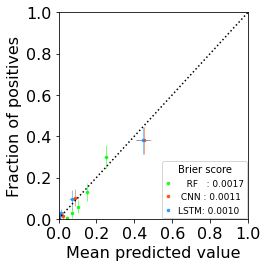

In [37]:
plot_calibration_curves('mortality', 48)

In [38]:
### End 